In [56]:
!pip install caer canaro

In [57]:
import os
import numpy as np
import cv2 as cv
import gc
import caer
import canaro

In [58]:
IMG_SIZE = (80,80)
channels = 1
char_path = r'/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset'

In [59]:
char_dict = {}
for char in os.listdir(char_path):
    char_dict[char] = len(os.listdir(os.path.join(char_path, char)))
    
#Sorting into descending order
char_dict = caer.sort_dict(char_dict, descending = True)
char_dict

[('homer_simpson', 2246),
 ('ned_flanders', 1454),
 ('moe_szyslak', 1452),
 ('lisa_simpson', 1354),
 ('bart_simpson', 1342),
 ('marge_simpson', 1291),
 ('krusty_the_clown', 1206),
 ('principal_skinner', 1194),
 ('charles_montgomery_burns', 1193),
 ('milhouse_van_houten', 1079),
 ('chief_wiggum', 986),
 ('abraham_grampa_simpson', 913),
 ('sideshow_bob', 877),
 ('apu_nahasapeemapetilon', 623),
 ('kent_brockman', 498),
 ('comic_book_guy', 469),
 ('edna_krabappel', 457),
 ('nelson_muntz', 358),
 ('lenny_leonard', 310),
 ('mayor_quimby', 246),
 ('waylon_smithers', 181),
 ('maggie_simpson', 128),
 ('groundskeeper_willie', 121),
 ('barney_gumble', 106),
 ('selma_bouvier', 103),
 ('carl_carlson', 98),
 ('ralph_wiggum', 89),
 ('patty_bouvier', 72),
 ('martin_prince', 71),
 ('professor_john_frink', 65),
 ('snake_jailbird', 55),
 ('cletus_spuckler', 47),
 ('rainier_wolfcastle', 45),
 ('simpsons_dataset', 42),
 ('agnes_skinner', 42),
 ('sideshow_mel', 40),
 ('otto_mann', 32),
 ('fat_tony', 27),
 (

In [60]:
characters = []
count = 0
for i in char_dict:
    characters.append(i[0])
    count+=1
    if count>=10:
        break
characters

['homer_simpson',
 'ned_flanders',
 'moe_szyslak',
 'lisa_simpson',
 'bart_simpson',
 'marge_simpson',
 'krusty_the_clown',
 'principal_skinner',
 'charles_montgomery_burns',
 'milhouse_van_houten']

In [61]:
train = caer.preprocess_from_dir(char_path, characters, channels = channels, IMG_SIZE = IMG_SIZE, isShuffle = True)

[INFO] Could not find a file to load from. Generating the training data
----------------------------------------------
[INFO] At 1000 files
[INFO] At 2000 files
[INFO] 2246 files found in 0.555283784866333s
[INFO] At 1000 files
[INFO] 1454 files found in 0.16033411026000977s
[INFO] At 1000 files
[INFO] 1452 files found in 0.2195122241973877s
[INFO] At 1000 files
[INFO] 1354 files found in 0.10036420822143555s
[INFO] At 1000 files
[INFO] 1342 files found in 0.09883332252502441s
[INFO] At 1000 files
[INFO] 1291 files found in 0.07775282859802246s
[INFO] At 1000 files
[INFO] 1206 files found in 0.05166745185852051s
[INFO] At 1000 files
[INFO] 1194 files found in 0.02880096435546875s
[INFO] At 1000 files
[INFO] 1193 files found in 0.029582738876342773s
[INFO] At 1000 files
[INFO] 1079 files found in 0.003573179244995117s
----------------------------------------------
[INFO] 13811 files preprocessed! Took 0m 55s


In [62]:
len(train)

13811

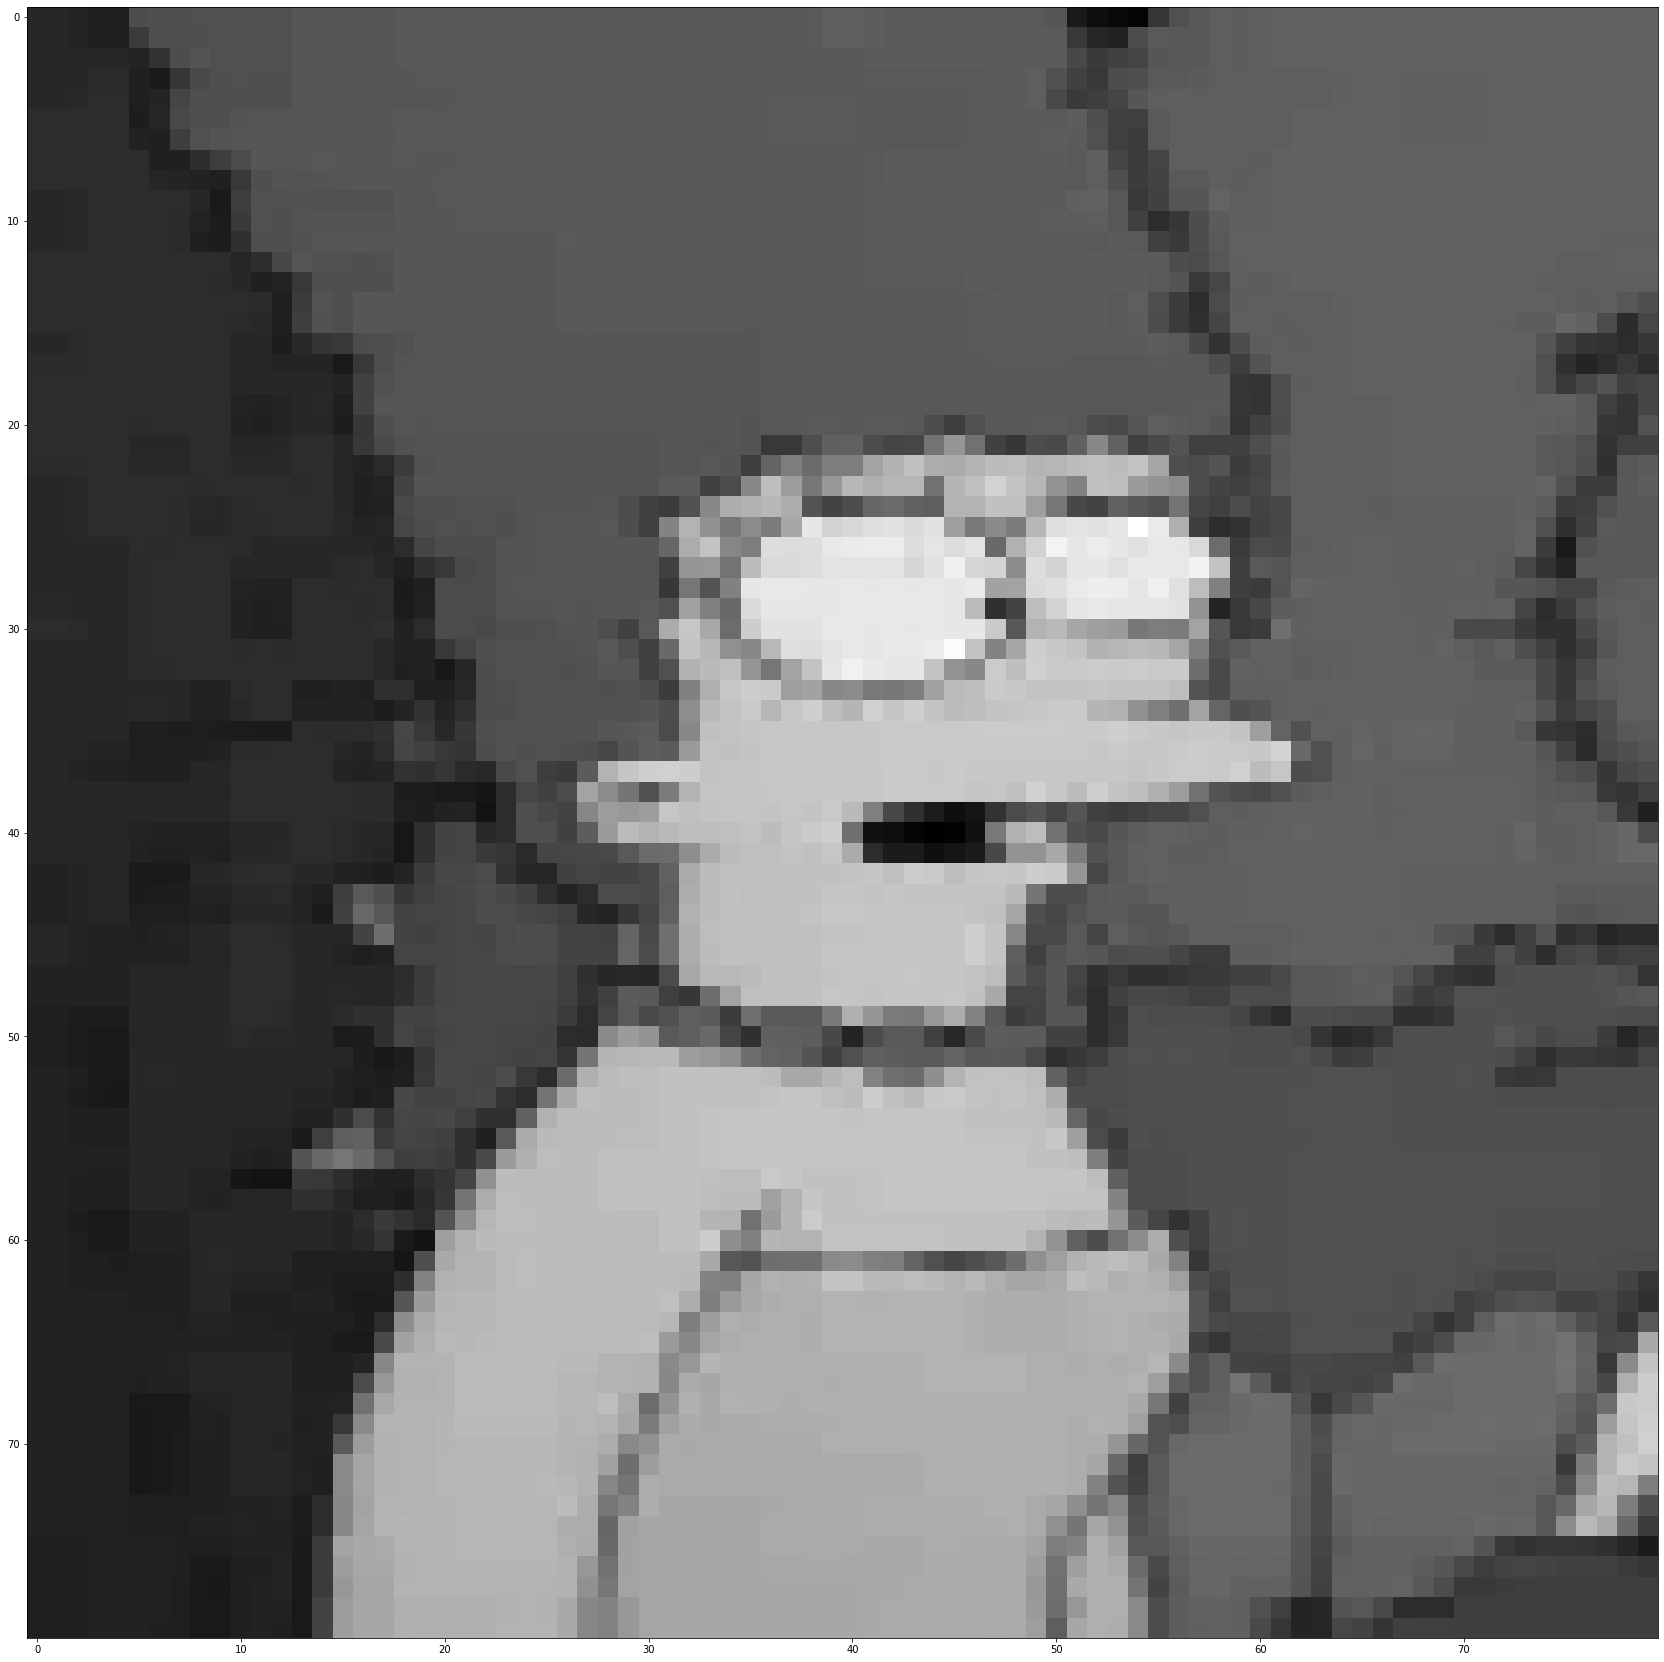

In [63]:
import matplotlib.pyplot as plt
plt.figure(figsize = (30,30))
plt.imshow(train[0][0], cmap = 'gray')
plt.show()

In [64]:
featureSet, labels = caer.sep_train(train, IMG_SIZE = IMG_SIZE)

In [65]:
from tensorflow.keras.utils import to_categorical
#Normalize the featureSet --->(0,1)
featureSet = caer.normalize(featureSet)
labels = to_categorical(labels, len(characters))

In [66]:
x_train, x_val, y_train, y_val = caer.train_val_split(featureSet, labels, val_ratio = .2)

In [67]:
del train
del featureSet
del labels
gc.collect()

1104

In [68]:
BATCH_SIZE = 32
EPOCHS = 10

In [69]:
datagen = canaro.generators.imageDataGenerator()
train_gen = datagen.flow(x_train, y_train, batch_size = BATCH_SIZE)

In [70]:
#Creating the model
model = canaro.models.createSimpsonsModel(IMG_SIZE = IMG_SIZE, channels = channels, output_dim = len(characters),
                                          loss = 'binary_crossentropy', decay = 1e-6, learning_rate = 0.001, momentum = 0.9, nesterov = True)

In [71]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 80, 80, 32)        320       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 78, 78, 32)        9248      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 39, 39, 32)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 39, 39, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 39, 39, 64)        18496     
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 37, 37, 64)        36928     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 18, 18, 64)       

In [72]:
from tensorflow.keras.callbacks import LearningRateScheduler
callbacks_list = [LearningRateScheduler(canaro.lr_schedule)]

In [73]:
training = model.fit(train_gen,
                     steps_per_epoch = len(x_train)//BATCH_SIZE,
                     epochs = EPOCHS,
                     validation_data = (x_val, y_val),
                     validation_steps = len(y_val)//BATCH_SIZE,
                     callbacks = callbacks_list)

Epoch 1/10
345/345 [==============================] - 12s 34ms/step - loss: 0.3417 - accuracy: 0.1544 - val_loss: 0.3330 - val_accuracy: 0.1520
Epoch 2/10
345/345 [==============================] - 11s 31ms/step - loss: 0.3234 - accuracy: 0.1632
Epoch 3/10
345/345 [==============================] - 11s 31ms/step - loss: 0.3228 - accuracy: 0.1654
Epoch 4/10
345/345 [==============================] - 11s 31ms/step - loss: 0.3184 - accuracy: 0.1792
Epoch 5/10
345/345 [==============================] - 12s 34ms/step - loss: 0.3075 - accuracy: 0.2219
Epoch 6/10
345/345 [==============================] - 11s 31ms/step - loss: 0.3028 - accuracy: 0.2471
Epoch 7/10
345/345 [==============================] - 12s 34ms/step - loss: 0.2996 - accuracy: 0.2680
Epoch 8/10
345/345 [==============================] - 11s 31ms/step - loss: 0.2972 - accuracy: 0.2746
Epoch 9/10
345/345 [==============================] - 11s 31ms/step - loss: 0.2942 - accuracy: 0.2849
Epoch 10/10
345/345 [===================

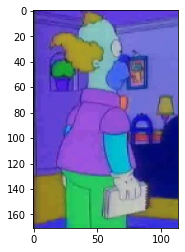

In [120]:
test_path = r'/kaggle/input/the-simpsons-characters-dataset/kaggle_simpson_testset/kaggle_simpson_testset/krusty_the_clown_10.jpg'
img = cv.imread(test_path)
plt.imshow(img, cmap = 'gray')
plt.show() 

In [121]:
def prepare(img):
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img = cv.resize(img, IMG_SIZE)
    img = caer.reshape(img, IMG_SIZE, 1)
    return img

In [122]:
predictions = model.predict(prepare(img))

In [123]:
predictions

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [124]:
print(characters[np.argmax(predictions[0])])

lisa_simpson
